In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

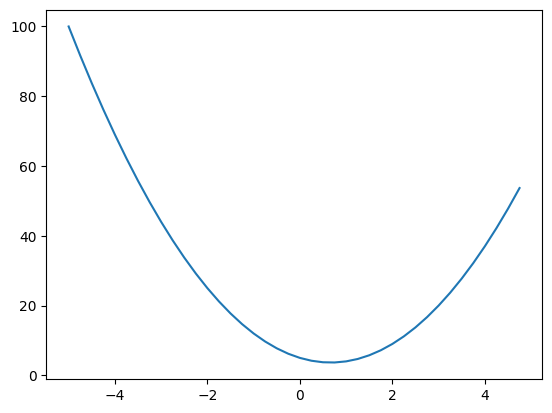

In [9]:
def f(x):
    return 3*x**2 - 4 * x + 5

f(3.0)

xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [14]:
h = 0.000001
x = -3
(f(x+h) - f(x))/h

-21.999997002808414

In [15]:
# Let's get more complex
a = 2
b = -3.0
c = 10
d = a*b+c
print(d)

4.0


In [18]:
h = 0.00001
a = 2
b = -3.0
c = 10

d1 = a*b+c
b += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.00002
slope 2.0000000000131024


In [86]:
class Value():

    def __init__(self, data: float, _children: tuple = (), _op: str = '', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._prev: set[Value] = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data}, prev=len({len(self._prev)}), op={self._op})"
    
    def __add__(self, other: 'Value') -> float:
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other: 'Value') -> float:
        return Value(self.data * other.data, (self, other), '*')
    
    @property
    def uid(self) -> str:
        """Return a unique id for the node"""
        return str(id(self))

    @property
    def op(self) -> str:
        """Return a printable label for the operation edge of the node"""
        return self._op

    @property
    def op_uid(self) -> str:
        """Return a printable label for the operation edge of the node"""
        return self.uid + self.op

    @property
    def data_label(self) -> str:
        """Return a printable label for the node"""
        return "{ %s | data %.4f | grad %.4f}" % (self.label, self.data, self.grad)
  

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"

In [73]:
print(d)


Value(data=4.0, prev=len(2), op=+)


In [87]:
from graphviz import Digraph

def trace(root: Value) -> tuple[set[Value], set[tuple[Value, Value]]]:
    nodes: set[Value] = set()
    edges: set[tuple[Value, Value]] = set()

    def build(v: Value):
        if v in nodes:
            return
        nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)

    build(root)
    return nodes, edges

def draw_dot(root: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for node in nodes:
        dot.node(name=node.uid, label=node.data_label, shape="record")
        # Add synthetic operation nodes when present
        if node.op:
            dot.node(name=node.op_uid, label=node.op)
            dot.edge(node.op_uid, node.uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

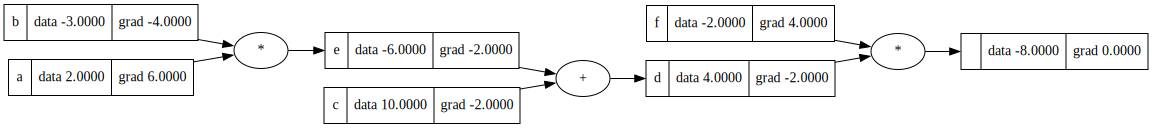

In [104]:
# Visualize the forward path
draw_dot(L)

In [103]:
L = d * f
# Symbolic expansion:
# dL/dd =? f
# (f(x+h)-f(x))/h
# ((d+h)*f - d*f)/h
# (d*f+h*f - d*f)/h
# h*f/h
# f

f.grad = 4.0  # value of d
d.grad = -2.0  # value of f


# Back propagation
# dL / dc =?
# If we wiggle c, how does that impact L through d? well we know how c impacts d
# then how d impacts L.
#
# dd / dc = ?
# Given d = c + e
#    -> dd / dc = 1 
#
# Deriving this:
# (f(x + h) - f(x) ) / h
#  = (c + h + e) - (c + e)) / h
#  = (c + h + e - c - e)/h
#  = (h/h) = 1
# So at the local + node d, it knows the dd/dc and dd/de, but that is just the local
# derivative. What we actually want is dL/dc.
# 
# We use the chain rule to calculate the difference.
# dL/dc = dL/dd * dd/dc
#       = -2 * 
# 
# If a car travels 4x as fast as a bicycle, and a bicycle travels 2x as fast as a walking
# person, then the car travels 8x faster than the walking person.

c.grad = -2.0
e.grad = -2.0

# Now let's do the a and b nodes.
# dL / de = -2
#
# e = a * b
# de / da = b
# de / da = a
#
# dL / da = (dL / de) * (de / da)
# dL / da = -2.0 * b
#
# dL / db = (dL / de) * (de / db)
# dL / db = -2.0 * a
a.grad = (-2 * -3)
b.grad = (-2 * 2)

In [107]:
L.grad = 1

def grad_experiment():
    """This is a test helper used to verify gradient at any node."""
    h = 0.0001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data


    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    b.data += h
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L2 = L.data 

    print((L2 - L1)/h)

grad_experiment()

-4.000000000008441


-8.0
-7.286496


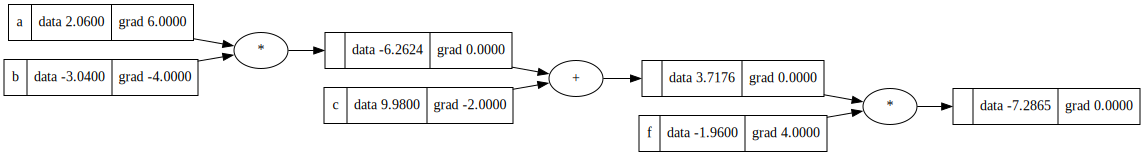

In [108]:
# Existing value
print(L.data)

# Try increasing the values in the direction of the gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
# Re-run the forward pass
e = a * b
d = e + c
L = d * f

# Updated value
print(L.data)
draw_dot(L)